In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='facebook/opt-350m'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'rank, alpha':[]}

In [4]:
g = 2
lr = 1.0e-5
wd = 0.01
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} focal loss, gamma: {g} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=2,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          accumulation_steps=2,
                          focalloss=True,
                          gamma=g,
                          early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['rank, alpha'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search facebook/opt-350m, learning rate 1e-05 focal loss, gamma: 2 wd: 0.01, Lora alpha 8, rank 8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	2.2066	Val Loss:	1.9028	Accuracy:	0.4286	F1:	0.3383
2 / 30: Train Loss:	1.7916	Val Loss:	1.7109	Accuracy:	0.3529	F1:	0.2785
3 / 30: Train Loss:	1.4225	Val Loss:	1.5617	Accuracy:	0.3950	F1:	0.3825
4 / 30: Train Loss:	1.2380	Val Loss:	1.5014	Accuracy:	0.3697	F1:	0.3676
5 / 30: Train Loss:	1.1933	Val Loss:	1.4438	Accuracy:	0.3782	F1:	0.3767
6 / 30: Train Loss:	1.1605	Val Loss:	1.3943	Accuracy:	0.3613	F1:	0.3620
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.33      0.58      0.42        38
oversimplification       0.35      0.22      0.27        36
slothful induction       0.57      0.38      0.45        45

          accuracy                           0.39       119
         macro avg       0.42      0.39      0.38       119
      weighted avg       0.43      0.39      0.39       119

test results:
                    precision    recall  f1

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	2.0962	Val Loss:	1.7971	Accuracy:	0.3866	F1:	0.3073
2 / 30: Train Loss:	1.4930	Val Loss:	1.5694	Accuracy:	0.3950	F1:	0.3814
3 / 30: Train Loss:	1.2410	Val Loss:	1.4849	Accuracy:	0.3613	F1:	0.3571
4 / 30: Train Loss:	1.1460	Val Loss:	1.4040	Accuracy:	0.3613	F1:	0.3617
5 / 30: Train Loss:	1.0814	Val Loss:	1.3365	Accuracy:	0.3193	F1:	0.3212
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.33      0.61      0.43        38
oversimplification       0.36      0.22      0.28        36
slothful induction       0.57      0.36      0.44        45

          accuracy                           0.39       119
         macro avg       0.42      0.39      0.38       119
      weighted avg       0.43      0.39      0.39       119

test results:
                    precision    recall  f1-score   support

 misrepresentation       0.30      0.64      0.41     

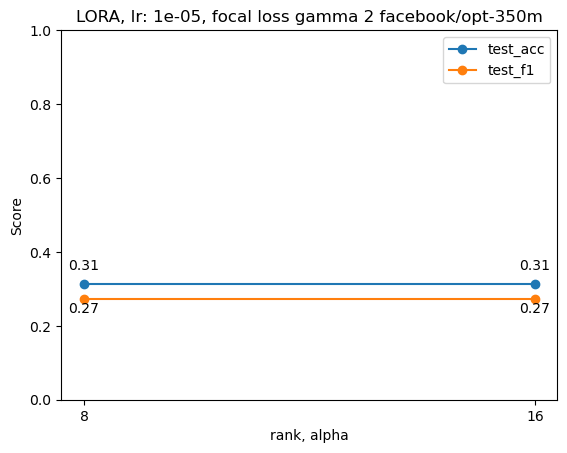

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'LORA, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='rank, alpha',
                        sci_format=False)

In [6]:
%reset -f